This file runs and generates results and figures for downstream tasks trained on ResNet152-generated features

In [1]:
# Import necessary packages: These include custom MOSAIKS packages contained within the repo, as well as standard Python packages.
%load_ext autoreload
%autoreload 2
%matplotlib inline

import io as b_io
import os
from pathlib import Path

import dill

# Import necessary packages
from mosaiks import config as c
from mosaiks import transforms
from mosaiks.utils.imports import *
from threadpoolctl import threadpool_limits

env variable MOSAIKS_HOME not defined; setting to: "/home/ubuntu/cs230/mosaiks-paper"
If not desired, please reset os.environ["MOSAIKS_NAME"]


In [2]:
num_threads = None

subset_n = slice(None)
subset_feat = slice(None)

fixed_lambda = False

if num_threads is not None:
    threadpool_limits(num_threads)
    os.environ["NUMBA_NUM_THREADS"] = str(num_threads)
    
solver = solve.ridge_regression

In [7]:
X = {}
latlons = {}

samples = [];
samples.append("UAR")
# samples.append("POP")

for sample in samples:
    # path to features X for UAR
    features_path = (
        Path(c.features_dir)
        / f"{c.features['pretrained']['model_type']}_pretrained_{c.grid['area']}_{c.images['zoom_level']}_{c.images['n_pixels']}_{sample}.pkl"
    )
    print(features_path)
    with open(features_path, "rb") as f:
        data = np.load(f, allow_pickle=True)
    print(len(data["X"]))
    print(type(data["X"]))
    print(len(data["latlon"]))
    temp = b_io.BytesIO(data["X"])
    temp2 = np.load(temp, allow_pickle=True)
    print(temp2.shape)
#     features = data["X"].astype(np.float64)
    features = temp2
    latlons_samp = data["latlon"]
    ids_x = data["ids_X"]

    X[sample] = pd.DataFrame(features, index=ids_x)
    latlons[sample] = pd.DataFrame(latlons_samp, index=ids_x, columns=["lat", "lon"])

latlons['UAR']
print(data["latlon"][:10])

/home/ubuntu/cs230/mosaiks-paper/data/int/feature_matrices/resnet152_pretrained_CONTUS_16_640_UAR.pkl
819200128
<class 'bytes'>
100000
(100000, 2048)
[[  37.93231386 -103.04673458]
 [  34.64757893  -91.20243831]
 [  32.07142741 -113.10061398]
 [  42.11671105  -72.00366039]
 [  34.54555235  -86.0240018 ]
 [  39.30945466  -87.88328086]
 [  35.90669922 -121.36407649]
 [  42.97905685  -84.46771635]
 [  33.13871114 -102.34434027]
 [  35.02060209  -79.57850103]]


Edit this to change what downstream task to run

In [29]:
labels_to_run = ["treecover"]

In [30]:
resultsDict = {}
label = labels_to_run[0]

print("*** Running regressions for: {}".format(label))

## Set some label-specific variables
this_cfg = io.get_filepaths(c, label)
c_app = getattr(this_cfg, label)
outcome_name = c_app["variable"]
sampling_type = c_app["sampling"]  # UAR or POP

best_lambda_fpath = join(c.fig_dir_sec, "best_lambda_tl.npz")
if fixed_lambda:
    lambdas = io.get_lambdas(c, label, best_lambda_fpath=best_lambda_fpath)
else:
    lambdas = io.get_lambdas(c, label, best_lambda_fpath=None)

if c_app["logged"]:
    bounds = np.array([c_app["us_bounds_log_pred"]])
else:
    bounds = np.array([c_app["us_bounds_pred"]])

# Set solver arguments
solver_kwargs = {
    "lambdas": lambdas,
    "return_preds": True,
    "svd_solve": False,
    "clip_bounds": bounds,
}

# Expand possible lambdas for this transfer learning feature set as needed so that
# the optimal lambda selected is not hitting the bounds of possible lambdas.
if (not fixed_lambda) and (label in ["income", "roads"]):
    solver_kwargs["lambdas"] = np.logspace(-3, 4, 9)

## get X, Y, latlon values of training data
(
    this_X,
    this_X_test,
    this_Y,
    this_Y_test,
    _,
    _,
) = parse.merge_dropna_transform_split_train_test(
    this_cfg, label, X[sampling_type], latlons[sampling_type]
)

## subset
this_X = this_X[subset_n, subset_feat]
this_X_test = this_X_test[:, subset_feat]
this_Y = this_Y[subset_n]

## Train model using ridge regression and 5-fold cross-valiation
## (number of folds can be adjusted using the argument n_folds)
print("Training model...")
kfold_results = solve.kfold_solve(
    this_X,
    this_Y,
    solve_function=solver,
    num_folds=this_cfg.ml_model["n_folds"],
    return_model=True,
    **solver_kwargs
)
print("")

## Store the metrics and the predictions from the best performing model
best_lambda_idx, best_metrics, best_preds = ir.interpret_kfold_results(
    kfold_results, "r2_score", hps=[("lambdas", solver_kwargs["lambdas"])]
)
best_lambdas = np.array(
    [solver_kwargs["lambdas"][np.asarray(best_lambda_idx).squeeze()]]
)

# save best lambdas
if subset_n == slice(None) and subset_feat == slice(None):
    np.savez(best_lambda_fpath, best_lambda=best_lambdas)

## Retrain a model using this best lambda:
holdout_results = solve.single_solve(
    this_X,
    this_X_test,
    this_Y,
    this_Y_test,
    lambdas=best_lambdas,
    return_preds=True,
    return_model=False,
    clip_bounds=bounds,
    svd_solve=False,
)

## Store the R2
resultsDict[label] = holdout_results["metrics_test"][0][0][0]["r2_score"]

*** Running regressions for: treecover
Loading labels...
Merging labels and features...
Splitting training/test...
Training model...
on fold (of 5): 1 2 3 4 5 


Plot results

Plotting treecover...


/home/ubuntu/anaconda3/envs/mosaiks-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubuntu/anaconda3/envs/mosaiks-env/lib/python3.9/site-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


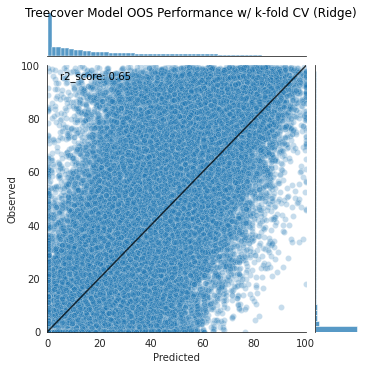

In [31]:
plots.performance_density(
    kfold_results,
    "Ridge",
    val=outcome_name,
    save_dir=None,
    app_name=label,
    kind="scatter",
    size=5
)